<a href="https://colab.research.google.com/github/santinabardengo/TDVIII/blob/main/Proyecto_Final_Clasificaci%C3%B3n_Binaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q efficientnet_pytorch
!pip install -Uq wandb

In [ ]:
import pandas as pd
import torch
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torch.nn as nn
import copy
from torchsummary import summary
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
import numpy as np
import torchvision.transforms as T
from PIL import Image
from torchvision import transforms
import wandb
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [ ]:
torch.manual_seed(162829)
if torch.cuda.is_available():
    torch.cuda.manual_seed(162829)

Wandb key : fd005b43ba216e7f8c0272801c9004c946bef281

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: caromilisanti44 (caromilisanti44-universidad-torcuato-di-tella). Use `wandb login --relogin` to force relogin


True

Conectamos el entorno a Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/Datos/train_data.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Datos/test_data.csv")

### Análisis explolatorio de datos

####Distribución de clases

<ipython-input-6-53561cd0476d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, x='label', palette='viridis', width=0.5)


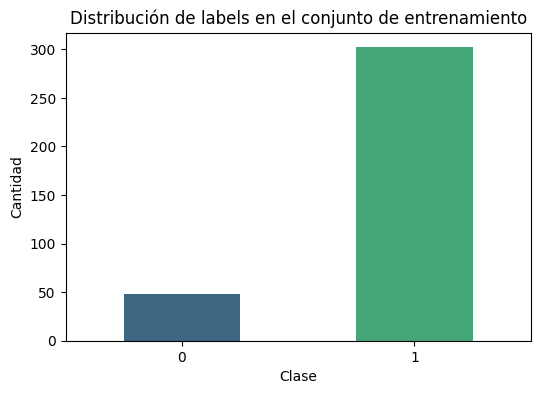

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=train_data, x='label', palette='viridis', width=0.5)
plt.title('Distribución de labels en el conjunto de entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.show()

<ipython-input-7-c64cb0383a66>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=test_data, x='label', palette='plasma', width = 0.5)


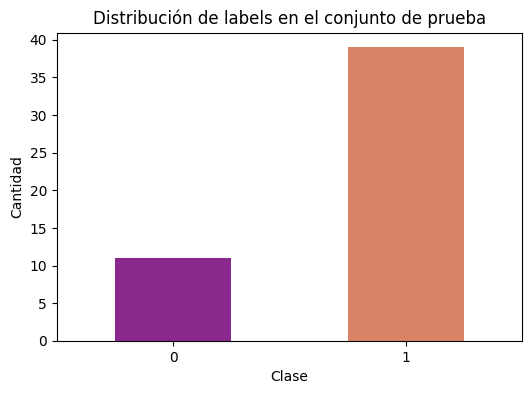

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=test_data, x='label', palette='plasma', width = 0.5)
plt.title('Distribución de labels en el conjunto de prueba')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.show()

####Imágenes según su clase

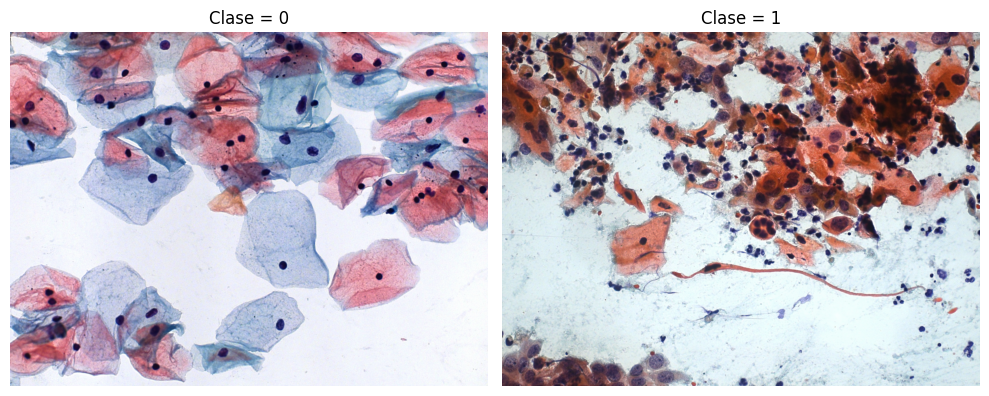

In [ ]:
class_0_image_path = train_data[train_data['label'] == 0].iloc[0]['image_filename']
class_1_image_path = train_data[train_data['label'] == 1].iloc[2]['image_filename']

class_0_image = Image.open("/content/drive/MyDrive/Datos/Images/" + class_0_image_path)
class_1_image = Image.open("/content/drive/MyDrive/Datos/Images/" + class_1_image_path)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(class_0_image)
axes[0].set_title('Clase = 0')
axes[0].axis('off')

axes[1].imshow(class_1_image)
axes[1].set_title('Clase = 1')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Cargamos los modelos EfficientNet preentrenados junto con el tamaño de imagen que le corresponde a cada uno según la versión

In [ ]:
models = {
    "EfficientNet-b0": EfficientNet.from_pretrained('efficientnet-b0'),
    "EfficientNet-b1": EfficientNet.from_pretrained('efficientnet-b1'),
    "EfficientNet-b2": EfficientNet.from_pretrained('efficientnet-b2'),
    "EfficientNet-b3": EfficientNet.from_pretrained('efficientnet-b3'),
    "EfficientNet-b3": EfficientNet.from_pretrained('efficientnet-b4'),
}

image_sizes = {
    "EfficientNet-b0": 224,
    "EfficientNet-b1": 240,
    "EfficientNet-b2": 260,
    'EfficientNet-b3': 300,
    'EfficientNet-b4': 380,
}

Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b1
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b3
Loaded pretrained weights for efficientnet-b4


###Parámetros del mejor modelo

In [ ]:
batch_size = 64
learning_rate = 1e-4
epochs = 150
experiment_name = "EfficientNetb0 - Random Augmentation - Final"
project_name = "Binary-PAPModel"
model_name = 'EfficientNet-b0'
interpolation_methods = [T.InterpolationMode.NEAREST, T.InterpolationMode.BILINEAR, T.InterpolationMode.BICUBIC]
interpolation = 'NearestInterpolation'
THRESHOLD = 0.4

In [ ]:
images_dir = '/content/drive/MyDrive/Datos/' + model_name + '/' + interpolation + '/'

###Tranformaciones para realizar la aumentación de los datos

In [ ]:
def image_transformations():
    '''
        Return transformations to be applied.
        Output:
            train_transformations: transformations to be applied on the training set
            valid_tfms: transformations to be applied on the validation or test set
    '''
    trans = [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]

    train_trans = [
            transforms.RandomRotation(90),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(contrast=0.2, brightness=0.2, saturation=0.2, hue=0.1)
    ]

    selected_transforms_train = random.sample(train_trans, 2)

    train_tfms = T.Compose(trans + selected_transforms_train)
    valid_tfms = T.Compose(trans)

    return train_tfms, valid_tfms

In [ ]:
def encode_label(label: list) -> list:
    return torch.tensor([label], dtype=torch.float32)

####Clase que se encarga de asociar el path de cada imagen a su archivo correspondiente y de realizar las transformaciones a las mismas durante el entrenamiento

In [ ]:
class PAPDataset(Dataset):

    def __init__(self, df, root_dir, transform):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.use_original_ratio = 0.4

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_fname, img_label = row['image_filename'], row['label']
        img = Image.open(self.root_dir + img_fname)

        # Random Augmentation
        if random.random() > self.use_original_ratio:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
            img = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(img)

        # Negative Augmentation
        # if img_label == 0 and random.random() > self.use_original_ratio:
        #     img = self.transform(img)
        # else:
        #   img = transforms.ToTensor()(img)
        #   img = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(img)

        return img, encode_label(img_label)

####Funciones para obtener train y test dataloader

In [ ]:
def get_train_dl(train_data, batch_size = 16):

    np.random.seed(162829)
    train_ds, val_ds = train_test_split(train_data, test_size = 0.3, random_state=162829, shuffle=True, stratify= train_data['label'])

    train_ds.reset_index(drop=True, inplace=True)
    val_ds.reset_index(drop=True, inplace=True)

    train_tfms, valid_tfms = image_transformations()

    train_ds = PAPDataset(train_ds, images_dir, transform = train_tfms)
    val_ds = PAPDataset(val_ds, images_dir, transform = valid_tfms)

    train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
    val_dl = torch.utils.data.DataLoader(val_ds, batch_size, shuffle=True, num_workers=2)

    return train_dl, val_dl

In [ ]:
def get_test_dl(test_data, batch_size = 16):

    _, test_tfms = image_transformations()

    test_data = PAPDataset(test_data, images_dir, transform = test_tfms)

    test_dl = torch.utils.data.DataLoader(test_data, batch_size, num_workers=2)

    return test_dl

####Función para calcular las métricas del modelo (accuracy, precision, recall y F1-score)

In [ ]:
def compute_metrics(TP: int, TN: int, FP: int, FN: int) -> float:

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP + 1e-12)
    recall = TP / (TP + FN + 1e-12)
    F1 = (2 * precision * recall) / (precision + recall + 1e-12)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'F1': F1,
    }

####Función para obtener la matriz de confusión


In [ ]:
def confusionMatrix(predicted: list, label: list):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(label, predicted), cmap='Blues', annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

###Definimos el modelo a utilizar (modelo EfficientNet preentrenado + FF)

In [ ]:
class PAPModel(nn.Module):
    def get_sequential(num_ftrs):
        linear_layers = nn.Sequential(
                nn.BatchNorm1d(num_features=num_ftrs),
                nn.Linear(num_ftrs, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),
                nn.Dropout(0.4),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.BatchNorm1d(num_features=128),
                nn.Dropout(0.4),
                nn.Linear(128, 1),
            )
        return linear_layers

    def __init__(self, model_name=None, model=None, input_size=None):
        super().__init__()

        self.model_name = model_name
        self.model = copy.deepcopy(model)
        self.IS = input_size

        self.num_ftrs = self.model._fc.in_features
        self.model._fc = PAPModel.get_sequential(self.num_ftrs)

    def forward(self, xb):
        return torch.sigmoid(self.model(xb))

    # Función para congelar los parámetros del modelo preentrenado
    def freeze(self):
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model._fc.parameters():
            param.requires_grad = True

    def unfreeze(self):
        for param in self.model.parameters():
            param.requires_grad = True

model = PAPModel(model_name, models[model_name], image_sizes[model_name])
model.to(device)

PAPModel(
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding(
   

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), learning_rate)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.95, patience=5, cooldown=1)

In [ ]:
wandb.init(
    project = project_name,
    name = experiment_name,
    entity = '',
    config={
        "baseModel": model_name,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs,
        "image_size": image_sizes[model_name],
        "optimizer": optimizer,
        "interpolation": interpolation,
    }
)

In [ ]:
train_dl, valid_dl = get_train_dl(train_data, batch_size)

###Entrenamos el modelo y nos guardamos el mejor según la función de pérdida

In [ ]:
best_val_score = 0
lowest_val_loss = float('inf')
best_epoch = 0

for epoch in range(epochs):

    running_loss = 0.0
    train_correct = 0
    TP_total = 0
    TN_total = 0
    FP_total = 0
    FN_total = 0
    total = 0

    #Entrenamiento
    model.train()
    for i, data in enumerate(train_dl, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs.data > THRESHOLD).float()
        total += labels.size(0)

        TP_total += ((predicted == 1) & (labels == 1)).sum().item()
        TN_total += ((predicted == 0) & (labels == 0)).sum().item()
        FP_total += ((predicted == 1) & (labels == 0)).sum().item()
        FN_total += ((predicted == 0) & (labels == 1)).sum().item()

    train_score = compute_metrics(TP_total, TN_total, FP_total, FN_total)
    running_loss = running_loss/total

    val_correct = 0
    total = 0
    val_loss = 0
    TP_total = 0
    TN_total = 0
    FP_total = 0
    FN_total = 0

    # Validacion
    with torch.no_grad():
        for data in valid_dl:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            predicted = (outputs.data > THRESHOLD).float()
            total += labels.size(0)

            val_loss += criterion(outputs, labels).item()

            TP_total += ((predicted == 1) & (labels == 1)).sum().item()
            TN_total += ((predicted == 0) & (labels == 0)).sum().item()
            FP_total += ((predicted == 1) & (labels == 0)).sum().item()
            FN_total += ((predicted == 0) & (labels == 1)).sum().item()

    # scheduler.step(val_loss)

    val_score = compute_metrics(TP_total, TN_total, FP_total, FN_total)

    val_loss = val_loss / total

    print(f'{epoch + 1} / {epochs}, lr: {optimizer.param_groups[0]["lr"]:.6f}, train loss: {running_loss:.3f}, val loss: {val_loss:.3f}, train_score: {train_score}, val_score: {val_score}')

    wandb.log({ "train_score": train_score, "val_score": val_score, "train_loss": running_loss,
             "val_loss": val_loss})

    # Si la pérdida en validación fue mas baja, guardamos ese modelo
    if val_loss < lowest_val_loss:
      best_epoch = epoch
      lowest_val_loss = val_loss

      print(f"Guardando el modelo para la época {best_epoch}, loss: {lowest_val_loss}")
      torch.save(model.state_dict(), f'{experiment_name}.pth')


print(f'Best Loss: {str(lowest_val_loss)}.')
print(f'Best Epoch: {str(best_epoch)}.')
print('Finished Training')

1 / 150, lr: 0.000100, train loss: 0.012, val loss: 0.014, train_score: {'accuracy': 0.6857142857142857, 'precision': 0.8722222222222173, 'recall': 0.7440758293838827, 'F1': 0.8030690537079389}, val_score: {'accuracy': 0.7238095238095238, 'precision': 0.9189189189189065, 'recall': 0.747252747252739, 'F1': 0.8242424242419194}
Guardando el modelo para la época 0, loss: 0.013702020758674258
2 / 150, lr: 0.000100, train loss: 0.011, val loss: 0.013, train_score: {'accuracy': 0.7061224489795919, 'precision': 0.9112426035502905, 'recall': 0.7298578199052098, 'F1': 0.8105263157889755}, val_score: {'accuracy': 0.7142857142857143, 'precision': 0.9178082191780697, 'recall': 0.7362637362637282, 'F1': 0.8170731707312034}
Guardando el modelo para la época 1, loss: 0.01321199167342413
3 / 150, lr: 0.000100, train loss: 0.010, val loss: 0.012, train_score: {'accuracy': 0.8, 'precision': 0.9550561797752756, 'recall': 0.8056872037914654, 'F1': 0.8740359897167227}, val_score: {'accuracy': 0.742857142857

In [ ]:
wandb.finish()

train_loss,█▇▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▄▄▃▃▃▃▃▃▃▂▂▃▃▂▂▃▂▂▁▁▁▁▂▁▁▂▂▁▁▂▁▃▁▁▁▁
train_loss,0.00087
val_loss,0.0018


#### Cargamos el mejor modelo

In [ ]:
PATH = './' + experiment_name + '.pth'
model.load_state_dict(torch.load(PATH, weights_only=True))

<ipython-input-28-6f6ff2794356>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [ ]:
test_dl = get_test_dl(test_data, batch_size=len(test_data))

###Utilizamos el mejor modelo para evaluar en el dataset de test

In [ ]:
model.eval()

all_preds = []
all_labels = []

TP_total = 0
TN_total = 0
FP_total = 0
FN_total = 0

with torch.no_grad():
  for data in test_dl:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model(images)
      predicted = (outputs.data > THRESHOLD).float()

      all_preds.extend(predicted.cpu().numpy().flatten())
      all_labels.extend(labels.cpu().numpy().flatten())

      TP_total += ((predicted == 1) & (labels == 1)).sum().item()
      TN_total += ((predicted == 0) & (labels == 0)).sum().item()
      FP_total += ((predicted == 1) & (labels == 0)).sum().item()
      FN_total += ((predicted == 0) & (labels == 1)).sum().item()

  for i in range(len(labels)):
      label = labels[i].cpu().item()  # Obtener el valor de la etiqueta
      prediction = predicted[i].cpu().item()  # Obtener el valor de la predicción
      print(f"Label = {label}, Predicción = {prediction}")

Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 0.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 0.0, Predicción = 0.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.0, Predicción = 1.0
Label = 1.

####Hacemos la matriz de confusión para los resultados de test e imprimimos las métricas

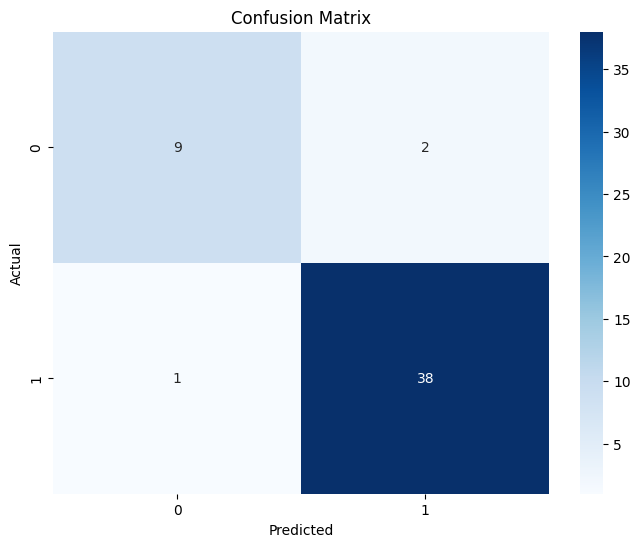

{'accuracy': 0.94, 'precision': 0.9499999999999762, 'recall': 0.9743589743589494, 'F1': 0.9620253164551719}


In [ ]:
confusionMatrix(all_preds, all_labels)
print(compute_metrics(TP_total, TN_total, FP_total, FN_total))